<a href="https://colab.research.google.com/github/RudyMartin/yelp/blob/main/YelpReviews_1_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis Over Time

# Analyzing Yelp Reviews with Embeddings, Clustering, and Summarization

Welcome! In this notebook, we'll explore how to analyze customer reviews for a set of Yelp Reviews. We'll use embeddings, clustering, and summarization techniques to understand the key themes and customer sentiment within the reviews.

Our goal is to determine whether Yelp review themes have shifted pre vs. post March 2020 (pre vs. post pandemic), or noticeably over other stretches of time.

Let's get started!

### Login to Google Colab at https://colab.research.google.com

In [21]:
# Import necessary libraries
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# careful we are assuming here you have no state secrets on your google drive and this is not a security risk.

Mounted at /content/drive


## Load the dataset

This English language dataset is from Kaggle: https://www.kaggle.com/datasets/farukalam/yelp/restaurant-reviews/data

You'll need to download it and place it in the same directory as this notebook or provide the correct path below.

For simplicity, I assume you have renamed the dataset CSV to 'Yelp Restaurant Reviews.csv'


In [22]:
# Load Data
# Set the path to your Yelp folder
file_name = 'Yelp Restaurant Reviews.csv'
data_path = '/content/drive/My Drive/yelp/'+file_name
data = pd.read_csv(data_path)
# Check columns to ensure 'Review Text' and 'Date' columns exist
print("Initial Columns in dataset:", data.columns)

Initial Columns in dataset: Index(['Yelp URL', 'Rating', 'Date', 'Review Text'], dtype='object')


In [23]:
# ## Libraries and Data Import

import pandas as pd
import numpy as np
import openai
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [24]:
try:
    df_reviews = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: {file_name} not found. Please make sure the dataset file is in the same directory as this notebook or provide the full path to the file.")

# Display the first few rows to understand the data
print(df_reviews.head())
print(df_reviews.info())

Dataset loaded successfully.
                                            Yelp URL  Rating       Date  \
0  https://www.yelp.com/biz/sidney-dairy-barn-sidney       5  1/22/2022   
1  https://www.yelp.com/biz/sidney-dairy-barn-sidney       4  6/26/2022   
2  https://www.yelp.com/biz/sidney-dairy-barn-sidney       5   8/7/2021   
3  https://www.yelp.com/biz/sidney-dairy-barn-sidney       4  7/28/2016   
4  https://www.yelp.com/biz/sidney-dairy-barn-sidney       5  6/23/2015   

                                         Review Text  
0  All I can say is they have very good ice cream...  
1  Nice little local place for ice cream.My favor...  
2  A delicious treat on a hot day! Staff was very...  
3  This was great service and a fun crew! I got t...  
4  This is one of my favorite places to get ice c...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 


### Data Preparation
Add columns for pre-March-2020 and Review length to get additional metadata about the reviews. These will be used for groupings.

In [ ]:
# Preprocess Data
# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Pre_March_2020'] = data['Date'] < datetime(2020, 3, 1)
data['Review_Length'] = data['Review Text'].str.len()  # Calculate review length


## Ratings History

Based on this plot the number of top ratings (5) significantly outweighs the other classes. The same goes for the pre-pandemic data. These unbalanced sets have implications for building forecasting models. For now we are just exploring the data.

<Figure size 1400x700 with 0 Axes>

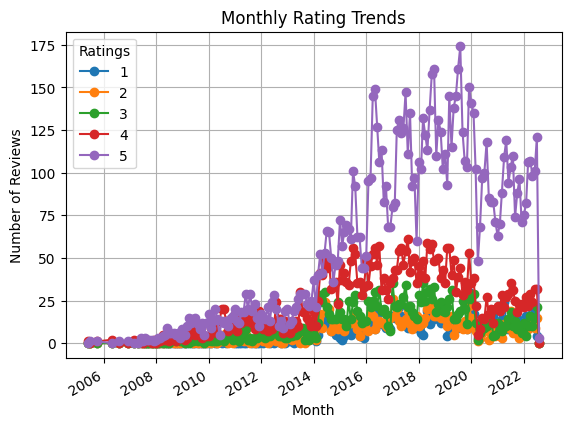

In [ ]:
# Resample data by month and count rating categories
# Use groupby with resample to group by rating and avoid KeyError
monthly_ratings = data.groupby([pd.Grouper(freq='MS'), 'Rating']).size().unstack().fillna(0)

# Plot the trends
plt.figure(figsize=(14, 7))
monthly_ratings.plot(kind='line', marker='o')
plt.title('Monthly Rating Trends')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title='Ratings')
plt.show()

## Sentiment Trends
This is highly positive text, which makes sense since the writer. just had a meal. There is no userID/geo indicators so our focus here will be on general categorical analysis. This works enough to draw conclusions about general user experiences. So no audience/maarket analysis here.  Note the increase in counts post 2013 has something to do with Yelp becoming a public company and making two acquisitions.  Basically, pre-2014 data is not on the same basis.

<Figure size 1400x700 with 0 Axes>

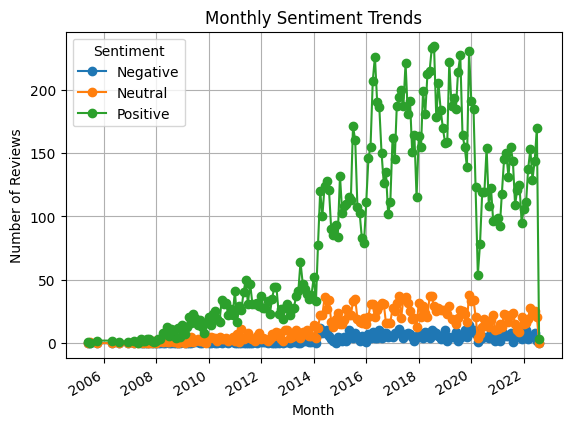

In [ ]:
# Define a function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to calculate polarity
data['Polarity'] = data['Review Text'].apply(get_sentiment)

# Define sentiment categories
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Classify sentiment based on polarity
data['Sentiment'] = data['Polarity'].apply(classify_sentiment)

# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the date as the index of the dataframe
data.set_index('Date', inplace=True)

# Resample data by month and count sentiment categories
# Use groupby with resample to avoid KeyError
monthly_sentiment = data.groupby(pd.Grouper(freq='MS'))['Sentiment'].value_counts().unstack().fillna(0)

# Plot the trends
plt.figure(figsize=(14, 7))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.legend(title='Sentiment')
plt.show()

In [ ]:
data

,Yelp URL,Rating,Review Text,Polarity,Sentiment
Date,,,,,
2022-01-22,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,All I can say is they have very good ice cream...,0.773333,Positive
2022-06-26,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,Nice little local place for ice cream.My favor...,0.273661,Positive
2021-08-07,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,A delicious treat on a hot day! Staff was very...,0.268750,Positive
2016-07-28,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,This was great service and a fun crew! I got t...,0.381250,Positive
2015-06-23,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,This is one of my favorite places to get ice c...,0.354082,Positive
...,...,...,...,...,...
2021-07-17,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,Had the chocolate cannoli! The filling was ric...,0.458333,Positive
2019-10-21,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,Love apricot croissant! I bought it at 4:00 PM...,0.498558,Positive
2019-10-12,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,Line was about 25 people long. It went fast! T...,0.397143,Positive


### Is there a correlation between sentiment and ratings?

In [ ]:
# Define a function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to calculate polarity
data['Polarity'] = data['Review Text'].apply(get_sentiment)

# Reset the index to make 'Date' a regular column again
data.reset_index(inplace=True)

# Filter data into two periods
data_pre_pandemic = data[(data['Date'] >= '2018-03-01') & (data['Date'] <= '2020-02-29')]
data_pandemic = data[(data['Date'] >= '2020-03-01') & (data['Date'] <= '2022-02-28')]


# Calculate the correlation between polarity and ratings for each period
correlation_pre_pandemic = data_pre_pandemic['Polarity'].corr(data_pre_pandemic['Rating'])
correlation_pandemic = data_pandemic['Polarity'].corr(data_pandemic['Rating'])

# Output the correlation results
print(f"Correlation between polarity and ratings from March 2018 to February 2020: {correlation_pre_pandemic}")
print(f"Correlation between polarity and ratings from March 2020 to February 2022: {correlation_pandemic}")









Correlation between polarity and ratings from March 2018 to February 2020: 0.5446313894346538
Correlation between polarity and ratings from March 2020 to February 2022: 0.5520963512620608


Let's get a closer visual look at sentiment and ratings.  

The charts below show the low ratings can have some positive tone to them. So this suggests a multi-class labeling solution might work better than simple definitions. Anyway we will have to be select about what we search for in this noisy data.

<ipython-input-54-b95612818294>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Rating', y=sentiment_label, data=data, ax=ax, palette=colors)
<ipython-input-54-b95612818294>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  barplot = sns.barplot(x='Rating', y=sentiment_label, data=data, ax=ax, palette=colors)
<ipython-input-54-b95612818294>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Rating', y=sentiment_label, data=data, ax=ax, palette=colors)
<ipython-input-54-b95612818294>:25: UserWarning: Numpy array is not a supported type for `palette`. Please convert your p

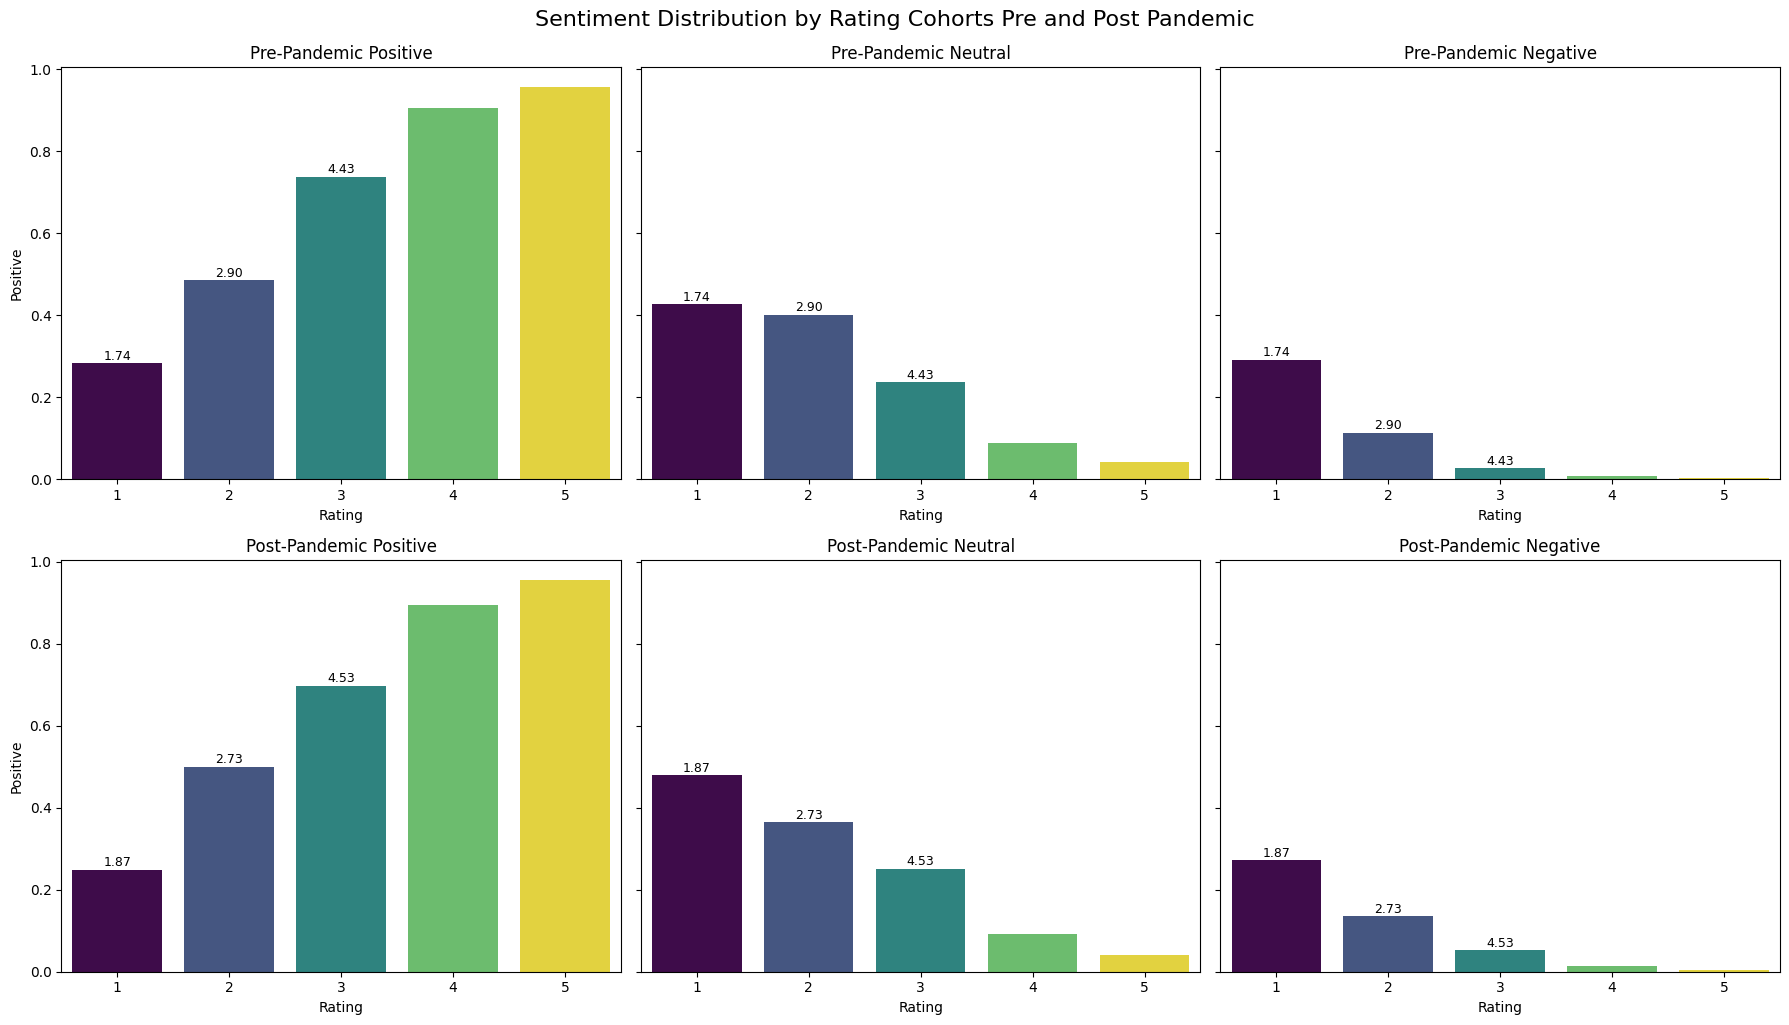

In [ ]:
# Function to prepare data for plotting
def get_sentiment_distribution(data_period):
    sentiment_dist = data_period.groupby(['Rating', 'Sentiment']).size().unstack(fill_value=0).reset_index()
    # Calculate the mean rating for each sentiment
    mean_ratings = data_period.groupby('Sentiment')['Rating'].mean()
    return sentiment_dist, mean_ratings

sentiment_counts_pre, mean_ratings_pre = get_sentiment_distribution(data_pre_pandemic)
sentiment_counts_post, mean_ratings_post = get_sentiment_distribution(data_pandemic)

# Normalize counts to sum to 1 (to get proportions)
sentiment_proportions_pre = sentiment_counts_pre.set_index('Rating').apply(lambda x: x / x.sum(), axis=1).reset_index()
sentiment_proportions_post = sentiment_counts_post.set_index('Rating').apply(lambda x: x / x.sum(), axis=1).reset_index()

# Create a colormap
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=sentiment_proportions_pre['Rating'].min(), vmax=sentiment_proportions_pre['Rating'].max())
sm = ScalarMappable(norm=norm, cmap=cmap)

# Plotting with gradient colors and annotations
fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

def plot_with_gradient(ax, data, sentiment_label, period_label, mean_ratings):
    colors = sm.to_rgba(data['Rating'])
    barplot = sns.barplot(x='Rating', y=sentiment_label, data=data, ax=ax, palette=colors)
    ax.set_title(f"{period_label} {sentiment_label}")
    # Annotate each bar with the average rating
    for p, mean_rating in zip(barplot.patches, mean_ratings):
        ax.annotate(f"{mean_rating:.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Plot pre-pandemic sentiment distribution by rating with gradient colors and average ratings
plot_with_gradient(axs[0, 0], sentiment_proportions_pre, 'Positive', 'Pre-Pandemic', mean_ratings_pre)
plot_with_gradient(axs[0, 1], sentiment_proportions_pre, 'Neutral', 'Pre-Pandemic', mean_ratings_pre)
plot_with_gradient(axs[0, 2], sentiment_proportions_pre, 'Negative', 'Pre-Pandemic', mean_ratings_pre)

# Plot post-pandemic sentiment distribution by rating with gradient colors and average ratings
plot_with_gradient(axs[1, 0], sentiment_proportions_post, 'Positive', 'Post-Pandemic', mean_ratings_post)
plot_with_gradient(axs[1, 1], sentiment_proportions_post, 'Neutral', 'Post-Pandemic', mean_ratings_post)
plot_with_gradient(axs[1, 2], sentiment_proportions_post, 'Negative', 'Post-Pandemic', mean_ratings_post)

plt.tight_layout()
plt.suptitle('Sentiment Distribution by Rating Cohorts Pre and Post Pandemic', fontsize=16, y=1.02)
plt.show()


## Ratings History Is the Key

Given what we discovered, let's focus on the 24 months before and 24 months after March 2020. This shows initial ratings went up as people discovered more restaurants and then the ratings trend dropped before recovering in early 2022.



<ipython-input-56-30eb63d3871d>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_average_ratings = data['Rating'].resample('M').mean()


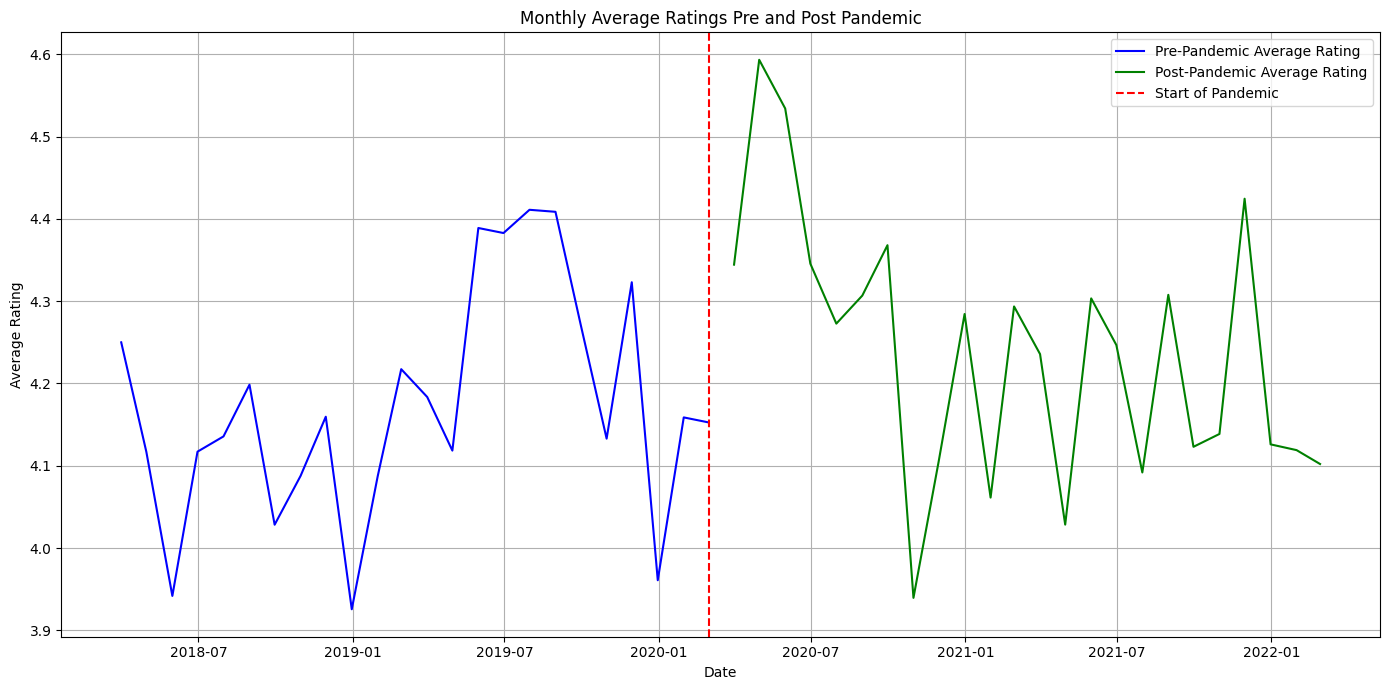

In [ ]:


# Resample data to get monthly average ratings
monthly_average_ratings = data['Rating'].resample('M').mean()

# Separate the data into pre-pandemic and post-pandemic periods
pre_pandemic_average = monthly_average_ratings['2018-03-01':'2020-02-29']
post_pandemic_average = monthly_average_ratings['2020-03-01':'2022-02-28']

# Plotting
plt.figure(figsize=(14, 7))
# Plot pre-pandemic monthly average ratings
plt.plot(pre_pandemic_average.index, pre_pandemic_average, label='Pre-Pandemic Average Rating', color='blue')
# Plot post-pandemic monthly average ratings
plt.plot(post_pandemic_average.index, post_pandemic_average, label='Post-Pandemic Average Rating', color='green')

# Add a vertical line to indicate the transition from pre-pandemic to post-pandemic
plt.axvline(x=pd.Timestamp('2020-03-01'), color='red', linestyle='--', label='Start of Pandemic')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Monthly Average Ratings Pre and Post Pandemic')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


Let's do a time-series decomposition so we can drill down on areas that are unusual. Wow!  This is highly seasonal data. Looking at the post 2014 trend component data the ratings were climbing until the fall of 2020 when outside dining was no longer possible in many areas of the country restaurant owners were challenged to meet local restrictions.

<ipython-input-61-077516b4ab7f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_average_ratings = data['Rating'].resample('M').mean()


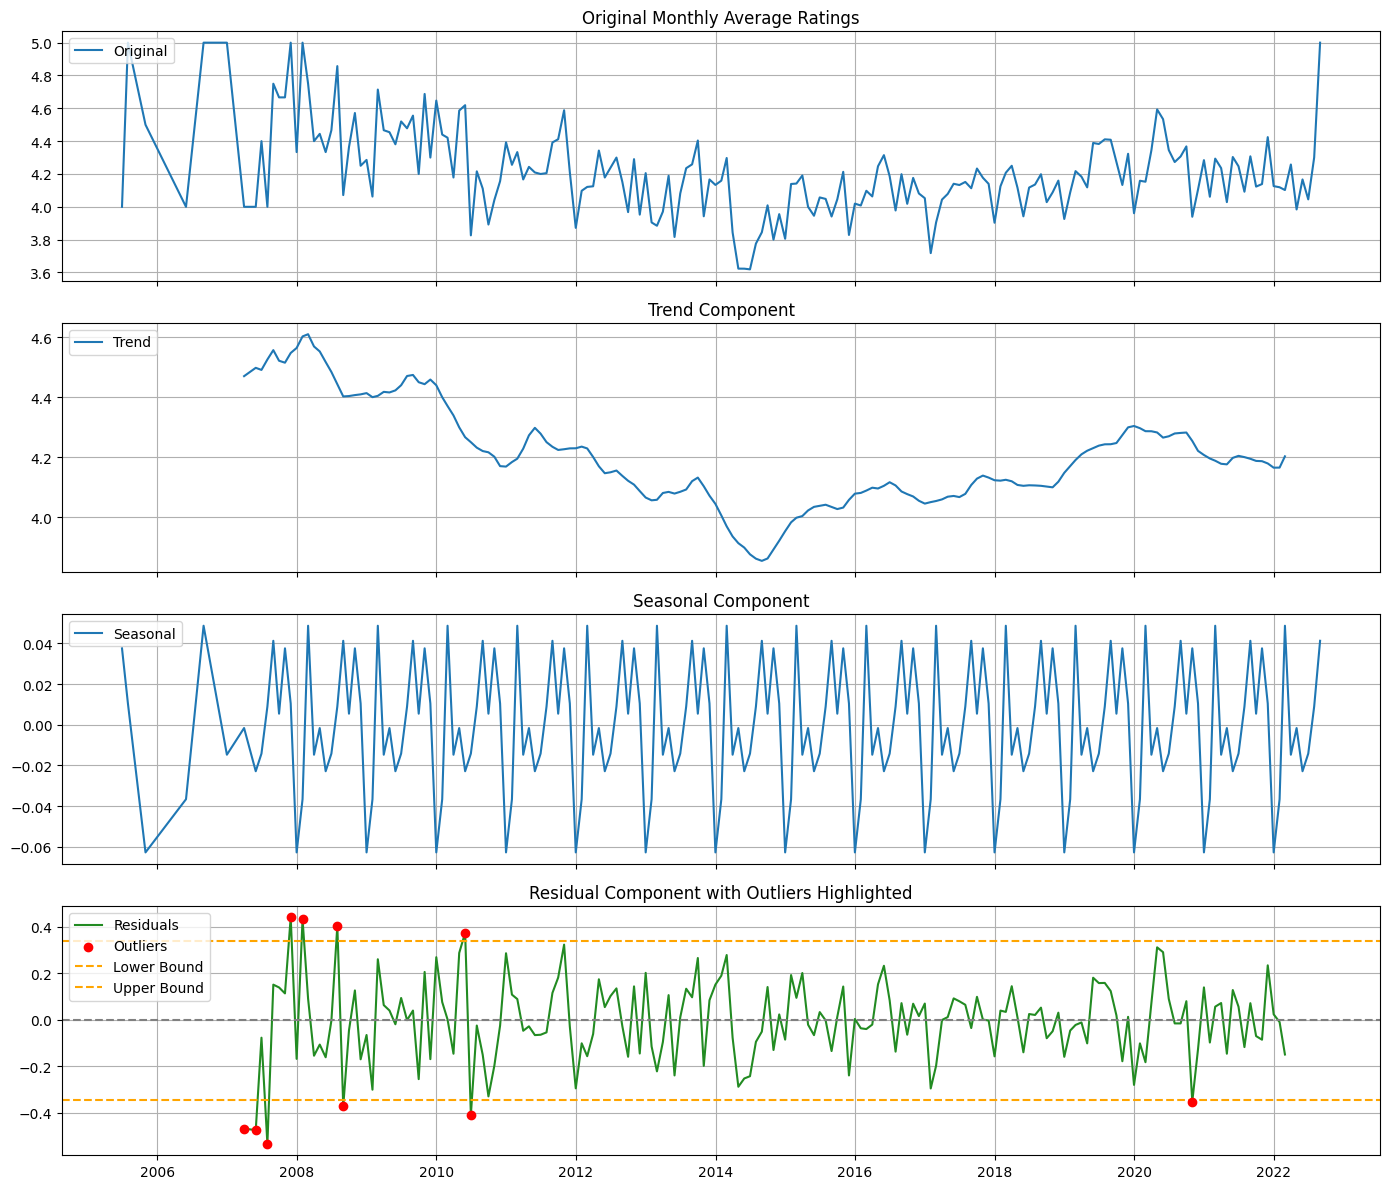

In [ ]:
# Resample data to get monthly average ratings
monthly_average_ratings = data['Rating'].resample('M').mean()

# Drop any NA values that could be present due to months with no data
monthly_average_ratings.dropna(inplace=True)

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_average_ratings, model='additive', period=12)

# Calculate the standard deviation and mean of the residuals
residuals = decomposition.resid.dropna()
mean_residual = residuals.mean()
std_residual = residuals.std()

# Define the threshold for outliers (e.g., 2 standard deviations from the mean)
threshold = 2
lower_bound = mean_residual - threshold * std_residual
upper_bound = mean_residual + threshold * std_residual

# Identify outliers
outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]

# Plotting the decomposed time series
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Residual component with outlier highlighting
axs[3].plot(residuals, label='Residuals', color='forestgreen')
axs[3].scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)  # Higher zorder to draw on top
axs[3].axhline(0, color='grey', linestyle='--')  # Add a zero line for reference
axs[3].axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound')
axs[3].axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound')
axs[3].set_title('Residual Component with Outliers Highlighted')
axs[3].legend()

# Add other components as before
# Original series
axs[0].plot(monthly_average_ratings, label='Original')
axs[0].set_title('Original Monthly Average Ratings')

# Trend component
axs[1].plot(decomposition.trend, label='Trend')
axs[1].set_title('Trend Component')

# Seasonal component
axs[2].plot(decomposition.seasonal, label='Seasonal')
axs[2].set_title('Seasonal Component')

# Common settings
for ax in axs:
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()